# Modelos de lenguaje neuronales

In [1]:
import pandas as pd
import torch
from NLPUtils import *
import re
import fasttext

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

Vamos a definir que un modelo de lenguaje sobre un vocabulario $V = \{ p_1, \ldots, p_{|V|}\}$ es la capacidad de asignarle una probabilidad $P(w_1,\ldots,w_n)$ a cada conjunto de palabras $w_1,\ldots,w_n$ pertenecientes al vocabulario $V$.

Para calcular esa probabilidad suele hacerse un modelo de N-gramas, en que vale la aproximación

$$
\begin{align*}
P(w_1,\ldots,w_n) &= P(w_n|w_{n-1},\ldots,w_1) P(w_{n-1}|w_{n-2},\ldots,w_1)\ldots P(w_2|w_1) P(w_1)\\[.5em]
&= \prod_{i=1}^n P(w_i|w_{i-1},\ldots,w_1)\\[.5em]
&\approx \prod_{i=1}^n P(w_i|w_{i-1},\ldots,w_{i-N+1})\\
\end{align*}
$$

Ahora, para estimar estas probabilidades, pueden usarse métodos distintos. Uno de ellos consiste en estimar por métodos frecuentistas estas probabilidades:

$$
P(w_i|w_{i-1},\ldots,w_{i-N+1}) = \frac{C(w_i,\ldots,w_{i-N+1})}{C(w_{i-1},\ldots,w_{i-N+1})}
$$

Otro de estos métodos consiste en modelar la probabilidad $P(w_i|w_{i-1},\ldots,w_{i-N+1})$ con una red neuronal y entrenar sus parámetros con algún modelo (por ejemplo, word2vec).

Para medir si un modelo de lenguaje es bueno, suele utilizarse la perplejidad sobre un corpus determinado. Si se tiene que ese corpus contiene $M$ palabras $w_1, \ldots, w_m$ pertenecientes a un vocabulario $V$, la perplejidad se define como

$$
Per(w_1,\ldots,w_m) = \left(\frac{1}{P(w_1,\ldots,w_m)} \right)^{1/M}
$$

y si se tiene un modelo de N-gramas, esta fórmula se convierte en:

$$
Per(w_1,\ldots,w_m) = \left(\prod_{i=1}^M\frac{1}{P(w_i|w_{i-1},\ldots,w_{1-N+1})} \right)^{1/M}
$$

## Modelo de lenguaje frecuentista

El archivo `lm_l40` contiene la información del modelo de lenguaje estimado para un modelo de bigramas con el set de entrenamiento de la base de datos Latino-40. Con este dato, calculamos la perplejidad de este modelo de lenguaje sobre las frases de test.

In [2]:
# Obtenemos el modelo de lenguaje del método frecuentista:
with open('lm_l40_2', 'rb') as file:
    lm_file = file.read().decode('iso-8859-1')
    
def get_log_prob(w1,w2):
    match = re.search(r'([\-]?[\d]+[\.]?[\d]*)\t({} {})'.format(w1,w2),lm_file)
    if match is not None:
        log_prob, _ = match.groups()
        return float(log_prob)
    match_w1 = re.search(r'([\-]?[\d]+[\.]?[\d]*)\t({})\t*(\-?[\d]*[\.]?[\d]*)'.format(w1),lm_file)
    match_w2 = re.search(r'([\-]?[\d]+[\.]?[\d]*)\t({})\t*(\-?[\d]*[\.]?[\d]*)'.format(w2),lm_file)
    return float(match_w1.groups()[0]) + float(match_w2.groups()[2])   
        
# Juntamos el corpus de test en una sola lista:
with open('promptsl40.test','rb') as file:
    test_lines = file.readlines()
    test_lines = [' '.join(re.findall(r'\w+',line.decode('iso-8859-1'))[1:]) for line in test_lines]
    corpus_test = [line.split(' ') for line in test_lines]
    corpus_test = [word for line in corpus_test for word in line]

In [3]:
# Perplejidad para un modelo de bigrama:
corpus_len = len(corpus_test)
log_p = [get_log_prob(corpus_test[idx-1],corpus_test[idx]) for idx in range(1,corpus_len)]
log_p.insert(0,float(re.search(r'([\-]?[\d]+[\.]?[\d]*)\t({})\t*(\-?[\d]*[\.]?[\d]*)'.format(corpus_test[0]),lm_file).groups()[0]))
print('El logaritmo de la perplejidad para el corpus de test es: {}'.format(sum(log_p)/corpus_len))

El logaritmo de la perplejidad para el corpus de test es: 1.7141915461883455


## Modelo de lenguaje neuronal

Cargamos el corpus de texto, conformado por todas las frases del conjunto de train.

In [3]:
with open('trainLM2.txt', 'rb') as file:
    lines = file.readlines()
    corpus = [line.decode('iso-8859-1').split(' ')[:-1] for line in lines]
    
print('Mostramos las primeras 10 frases del corpus:')
for i in range(10):
    print(corpus[i])
    
corpus = [[token for doc in corpus for token in doc]]

Mostramos las primeras 10 frases del corpus:
['no', 'habiendo', 'objeciones', 'así', 'quedó', 'acordado']
['a', 'fin', 'de', 'año', 'hará', 'el', 'balance', 'de', 'la', 'situación']
['este', 'programa', 'debe', 'ejecutarse', 'en', 'todos', 'los', 'niveles']
['no', 'debe', 'interpretarse', 'esto', 'como', 'que', 'uno', 'es', 'más', 'rico']
['la', 'pareja', 'partió', 'esta', 'madrugada', 'para', 'la', 'capital']
['a', 'la', 'sazón', 'los', 'locales', 'no', 'disfrutaban', 'de', 'inviolabilidad']
['la', 'princesa', 'del', 'japón', 'niega', 'que', 'esté', 'embarazada']
['la', 'esposa', 'y', 'su', 'hija', 'estaban', 'con', 'el', 'cantante', 'en', 'roma']
['ninguno', 'de', 'los', 'ataques', 'causó', 'daños', 'ni', 'heridos']
['esto', 'dio', 'lugar', 'a', 'que', 'se', 'reabrieran', 'ciertos', 'casos']


In [28]:
window_size = 8           # Tamaño de la ventana del contexto.
cutoff_freq = 0           # Palabras con una frecuencia menor o igual a cutoff_freq son excluídas del vocabulario.
batch_size = 512          # Tamaño del batch.

model = 'CBOW'            # Método de entrenamiento.
embedding_dim = 200       # Dimensión del espacio de los word vectors.
device = 'cuda:1'         # Dispositivo sobre el cual se entrena. 
state_dict = None         # Parámetros pre-entrenados.
paralelize = False        # Flag para decirle al programa que use las 2 gpus

epochs = 100              # Cantidad de epochs
learning_rate = 5e-4      # Tasa de aprendizaje
sample_loss_every = 10    # Calcular la loss cada este número
algorithm = 'Adam'        # Algoritmo de optimización

trainer = Word2vecTrainer(corpus,cutoff_freq=cutoff_freq,window_size=window_size,batch_size=batch_size)
trainer.InitModel(model=model, state_dict=state_dict, device=device, paralelize=paralelize, embedding_dim=embedding_dim)
trainer.Train(algorithm=algorithm, epochs=epochs, sample_loss_every=sample_loss_every, lr=learning_rate)

Word2vec trainer created:
Window size: 8
Number of samples: 38960
Vocabulary Size: 5922
Number of batches: 77
Number of samples per batch: 512

Dispositivo seleccionado: cuda:1
Dimensión del espacio de los embeddings: 200
Starting training...
Optimization method: Adam
Learning Rate: 0.0005
Number of epochs: 100
Running on device (cuda:1)

Epoch: 1, Batch number: 0, Loss: 4456.3095703125
Epoch: 1, Batch number: 10, Loss: 4422.64501953125
Epoch: 1, Batch number: 20, Loss: 4407.53759765625
Epoch: 1, Batch number: 30, Loss: 4378.29736328125
Epoch: 1, Batch number: 40, Loss: 4350.97265625
Epoch: 1, Batch number: 50, Loss: 4305.6318359375
Epoch: 1, Batch number: 60, Loss: 4282.6748046875
Epoch: 1, Batch number: 70, Loss: 4253.68505859375
Epoch: 2, Batch number: 3, Loss: 4197.9814453125
Epoch: 2, Batch number: 13, Loss: 4153.50732421875
Epoch: 2, Batch number: 23, Loss: 4123.61279296875
Epoch: 2, Batch number: 33, Loss: 4085.4453125
Epoch: 2, Batch number: 43, Loss: 4058.816650390625
Epoch: 2

Epoch: 21, Batch number: 0, Loss: 2482.201904296875
Epoch: 21, Batch number: 10, Loss: 2459.947509765625
Epoch: 21, Batch number: 20, Loss: 2487.768798828125
Epoch: 21, Batch number: 30, Loss: 2440.846923828125
Epoch: 21, Batch number: 40, Loss: 2456.12548828125
Epoch: 21, Batch number: 50, Loss: 2438.884765625
Epoch: 21, Batch number: 60, Loss: 2471.957763671875
Epoch: 21, Batch number: 70, Loss: 2420.897216796875
Epoch: 22, Batch number: 3, Loss: 2446.44384765625
Epoch: 22, Batch number: 13, Loss: 2394.55126953125
Epoch: 22, Batch number: 23, Loss: 2390.009765625
Epoch: 22, Batch number: 33, Loss: 2380.3291015625
Epoch: 22, Batch number: 43, Loss: 2401.007080078125
Epoch: 22, Batch number: 53, Loss: 2434.263916015625
Epoch: 22, Batch number: 63, Loss: 2447.40966796875
Epoch: 22, Batch number: 73, Loss: 2450.744140625
Epoch: 23, Batch number: 6, Loss: 2400.44189453125
Epoch: 23, Batch number: 16, Loss: 2356.5693359375
Epoch: 23, Batch number: 26, Loss: 2317.456787109375
Epoch: 23, Bat

Epoch: 41, Batch number: 40, Loss: 1650.41845703125
Epoch: 41, Batch number: 50, Loss: 1645.88037109375
Epoch: 41, Batch number: 60, Loss: 1686.0028076171875
Epoch: 41, Batch number: 70, Loss: 1642.690185546875
Epoch: 42, Batch number: 3, Loss: 1551.698486328125
Epoch: 42, Batch number: 13, Loss: 1601.7996826171875
Epoch: 42, Batch number: 23, Loss: 1535.234375
Epoch: 42, Batch number: 33, Loss: 1609.54150390625
Epoch: 42, Batch number: 43, Loss: 1596.857177734375
Epoch: 42, Batch number: 53, Loss: 1572.1253662109375
Epoch: 42, Batch number: 63, Loss: 1626.4912109375
Epoch: 42, Batch number: 73, Loss: 1664.8046875
Epoch: 43, Batch number: 6, Loss: 1610.76513671875
Epoch: 43, Batch number: 16, Loss: 1582.847412109375
Epoch: 43, Batch number: 26, Loss: 1559.2476806640625
Epoch: 43, Batch number: 36, Loss: 1434.0828857421875
Epoch: 43, Batch number: 46, Loss: 1544.0146484375
Epoch: 43, Batch number: 56, Loss: 1641.2703857421875
Epoch: 43, Batch number: 66, Loss: 1619.6778564453125
Epoch: 

Epoch: 61, Batch number: 70, Loss: 1173.9678955078125
Epoch: 62, Batch number: 3, Loss: 1106.77197265625
Epoch: 62, Batch number: 13, Loss: 1128.6519775390625
Epoch: 62, Batch number: 23, Loss: 1150.6558837890625
Epoch: 62, Batch number: 33, Loss: 1149.5418701171875
Epoch: 62, Batch number: 43, Loss: 1130.2489013671875
Epoch: 62, Batch number: 53, Loss: 1165.385009765625
Epoch: 62, Batch number: 63, Loss: 1115.304443359375
Epoch: 62, Batch number: 73, Loss: 1116.717041015625
Epoch: 63, Batch number: 6, Loss: 1064.6600341796875
Epoch: 63, Batch number: 16, Loss: 1127.4417724609375
Epoch: 63, Batch number: 26, Loss: 1074.7193603515625
Epoch: 63, Batch number: 36, Loss: 1084.9306640625
Epoch: 63, Batch number: 46, Loss: 1177.590576171875
Epoch: 63, Batch number: 56, Loss: 1159.5194091796875
Epoch: 63, Batch number: 66, Loss: 1190.165771484375
Epoch: 63, Batch number: 76, Loss: 108.14066314697266
Epoch: 64, Batch number: 9, Loss: 1093.0357666015625
Epoch: 64, Batch number: 19, Loss: 1087.1

Epoch: 82, Batch number: 23, Loss: 809.3721313476562
Epoch: 82, Batch number: 33, Loss: 791.450439453125
Epoch: 82, Batch number: 43, Loss: 834.5232543945312
Epoch: 82, Batch number: 53, Loss: 762.3238525390625
Epoch: 82, Batch number: 63, Loss: 788.8572387695312
Epoch: 82, Batch number: 73, Loss: 842.5316162109375
Epoch: 83, Batch number: 6, Loss: 746.2217407226562
Epoch: 83, Batch number: 16, Loss: 755.044189453125
Epoch: 83, Batch number: 26, Loss: 813.5361938476562
Epoch: 83, Batch number: 36, Loss: 756.3292236328125
Epoch: 83, Batch number: 46, Loss: 826.2319946289062
Epoch: 83, Batch number: 56, Loss: 843.1263427734375
Epoch: 83, Batch number: 66, Loss: 776.3576049804688
Epoch: 83, Batch number: 76, Loss: 62.839622497558594
Epoch: 84, Batch number: 9, Loss: 753.477294921875
Epoch: 84, Batch number: 19, Loss: 741.9276123046875
Epoch: 84, Batch number: 29, Loss: 739.78759765625
Epoch: 84, Batch number: 39, Loss: 737.3778686523438
Epoch: 84, Batch number: 49, Loss: 793.9525146484375

<IPython.core.display.Javascript object>


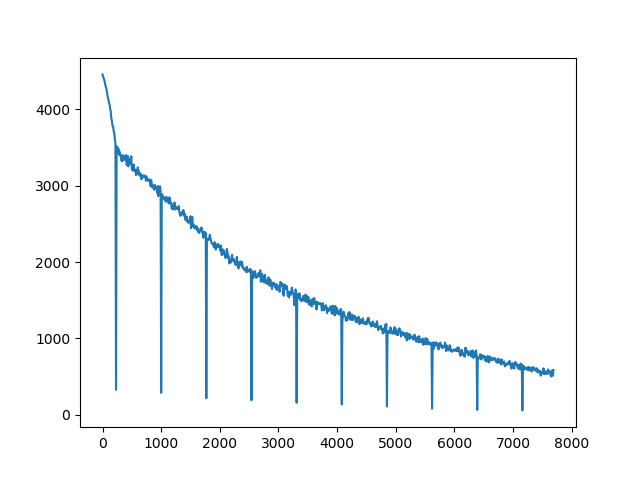

In [29]:
fig, ax = plt.subplots()
ax.plot(trainer.loss_history['iter'],trainer.loss_history['loss'])

In [30]:
# Perplejidad para un modelo de bigrama:
corpus_len = len(corpus_test)
vocab = Vocabulary.from_corpus([corpus_test])
trainer.model.eval()
x = torch.tensor([vocab[corpus_test[0]]],device=torch.device(device))
scores = trainer.model.out(trainer.model.emb(x)).squeeze(0)
log_p_nn = [scores[vocab[corpus_test[0]]] - torch.logsumexp(scores,dim=0)]
for idx in range(1,corpus_len):
    x = torch.tensor([vocab[corpus_test[idx-1]]],device=torch.device(device))
    scores = trainer.model.out(trainer.model.emb(x)).squeeze(0)
    log_p_nn.append(scores[vocab[corpus_test[idx]]] - torch.logsumexp(scores,dim=0))

trainer.model.train()
print('El logaritmo de la perplejidad para el corpus de test es: {}'.format(sum(log_p_nn)/corpus_len))

El logaritmo de la perplejidad para el corpus de test es: -32.82915496826172


In [7]:
import numpy as np

In [17]:
l = ['wa', 'wb', 'wc', '<s>', '</s>']
r = np.random.randint(0,5,10000)
ll = [l[i] for i in r]
t = ' '.join(ll)
print('wa wa' in t)
print('wa wb' in t)
print('wa wc' in t)
print('wa <s>' in t)
print('wa </s>' in t)
print('wb wa' in t)
print('wb wb' in t)
print('wb wc' in t)
print('wb <s>' in t)
print('wb </s>' in t)
print('wc wa' in t)
print('wc wb' in t)
print('wc wc' in t)
print('wc <s>' in t)
print('wc </s>' in t)
print('<s> wa' in t)
print('<s> wb' in t)
print('<s> wc' in t)
print('<s> <s>' in t)
print('<s> </s>' in t)
print('</s> wa' in t)
print('</s> wb' in t)
print('</s> wc' in t)
print('</s> <s>' in t)
print('</s> </s>' in t)
print(t)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
wc wc wc wa wb <s> </s> wa </s> </s> wc <s> </s> <s> <s> wc <s> wc wa wb </s> wa wa wc <s> wb <s> wc wa wb </s> </s> </s> </s> wc <s> </s> </s> <s> <s> <s> wb <s> wa <s> wb <s> <s> wa </s> wc wc wa </s> wb wb </s> wb <s> wc </s> </s> <s> wa wc wc <s> wc <s> wa wc wa wb </s> wb wc </s> wb wa wc wa wa wc wa wb wb wb wb <s> <s> wc wc </s> wb wb wc <s> wb wb </s> wa </s> </s> wa <s> wb </s> wb wc wb wb wb </s> <s> wb wc </s> wc wb wa </s> wb wa wb wc <s> wb wb wb wa wa <s> wc </s> wc wa wa wa wb <s> </s> </s> wc wb </s> <s> <s> wb wa <s> </s> </s> wa wc <s> wa wc <s> wa <s> </s> </s> wb </s> <s> wb wa <s> <s> wb <s> wa </s> wb </s> <s> wc wa wb wb </s> </s> wa wa wb wc </s> wc </s> wc wa wb wb wb wa </s> </s> wa wa wa wb wc wb wb </s> </s> </s> wb </s> wa wb <s> </s> wa <s> wc <s> <s> </s> wb wb <s> wa wc wb <s> </s> <s> wc wa wb <s> </s> </s> wa wb wb wb wb wb <s> <

In [20]:
print('wa wa',t.count('wa wa'))
print('wa wb',t.count('wa wb'))
print('wa wc',t.count('wa wc'))
print('wa <s>',t.count('wa <s>'))
print('wa </s>',t.count('wa </s>'))
print('wb wa',t.count('wb wa'))
print('wb wb',t.count('wb wb'))
print('wb wc',t.count('wb wc'))
print('wb <s>',t.count('wb <s>'))
print('wb </s>',t.count('wb </s>'))
print('wc wa',t.count('wc wa'))
print('wc wb',t.count('wc wb'))
print('wc wc',t.count('wc wc'))
print('wc <s>',t.count('wc <s>'))
print('wc </s>',t.count('wc </s>'))
print('<s> wa',t.count('<s> wa'))
print('<s> wb',t.count('<s> wb'))
print('<s> wc',t.count('<s> wc'))
print('<s> <s>',t.count('<s> <s>'))
print('<s> </s>',t.count('<s> </s>'))
print('</s> wa',t.count('</s> wa'))
print('</s> wb',t.count('</s> wb'))
print('</s> wc',t.count('</s> wc'))
print('</s> <s>',t.count('</s> <s>'))
print('</s> </s>',t.count('</s> </s>'))

wa wa 367
wa wb 427
wa wc 374
wa <s> 405
wa </s> 413
wb wa 409
wb wb 318
wb wc 405
wb <s> 417
wb </s> 338
wc wa 418
wc wb 360
wc wc 339
wc <s> 400
wc </s> 410
<s> wa 419
<s> wb 403
<s> wc 414
<s> <s> 350
<s> </s> 372
</s> wa 373
</s> wb 379
</s> wc 394
</s> <s> 386
</s> </s> 349
